## Importações

In [1]:
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import laspy
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection
import uuid
import scipy.stats
import seaborn as sns

# from train_split import TrainSplit

# Split Geometry

In [2]:
def katana(geometry, threshold, count=0):
    """Split a Polygon into two parts across it's shortest dimension"""

    bounds = geometry.bounds

    width = bounds[2] - bounds[0]

    height = bounds[3] - bounds[1]

    if max(width, height) <= threshold or count == 250:

        # either the polygon is smaller than the threshold, or the maximum

        # number of recursions has been reached

        return [geometry]

    if height >= width:

        # split left to right

        a = box(bounds[0], bounds[1], bounds[2], bounds[1] + height / 2)

        b = box(bounds[0], bounds[1] + height / 2, bounds[2], bounds[3])

    else:

        # split top to bottom

        a = box(bounds[0], bounds[1], bounds[0] + width / 2, bounds[3])

        b = box(bounds[0] + width / 2, bounds[1], bounds[2], bounds[3])

    result = []

    for d in (
        a,
        b,
    ):

        c = geometry.intersection(d)

        if not isinstance(c, GeometryCollection):

            c = [c]

        for e in c:

            if isinstance(e, (Polygon, MultiPolygon)):

                result.extend(katana(e, threshold, count + 1))

    if count > 0:
        return result

    # convert multipart into singlepart

    final_result = []

    for g in result:

        if isinstance(g, MultiPolygon):

            final_result.extend(g)

        else:

            final_result.append(g)

    return final_result

# Carregamento dos dados

In [3]:
las = laspy.read(
    "C:/Users/joaov/Documents/UFMG/TCC/Dataset/DUC_A01_2017_LiDAR/DUC_A01_2017_LAS/DUCL0001C0004.las"
)

In [4]:
lidar_data = np.vstack(
    (
        las.X,
        las.Y,
        las.Z,
        las.intensity,
        las.return_number,
        las.number_of_returns,
        las.classification,
    )
).transpose()

In [5]:
lidar_dataset: pd.DataFrame = pd.DataFrame(
    lidar_data,
    columns=[
        "X",
        "Y",
        "Z",
        "intensity",
        "return_number",
        "number_of_returns",
        "classification",
    ],
)

In [6]:
lidar_dataset

,X,Y,Z,intensity,return_number,number_of_returns,classification
0,84100006,967470102,11312,1,1,2,1
1,84100009,967470069,11402,1,1,1,1
2,84100010,967470031,11397,1,1,1,1
3,84100011,967470014,11440,3,1,1,1
4,84100012,967469985,11455,2,1,1,1
...,...,...,...,...,...,...,...
17035413,84100000,967412571,11618,6,1,2,1
17035414,84100024,967412995,10716,1,2,2,1
17035415,84100022,967412966,10719,1,2,2,1
17035416,84100018,967412853,10407,1,2,2,1


In [7]:
lidar_dataset["X"] = lidar_dataset["X"] / 100
lidar_dataset["Y"] = lidar_dataset["Y"] / 100
lidar_dataset["Z"] = lidar_dataset["Z"] / 100

In [8]:
del las
del lidar_data

In [9]:
geo_lidar_dataset: geopandas.GeoDataFrame = geopandas.GeoDataFrame(
    lidar_dataset,
    geometry=geopandas.points_from_xy(
        lidar_dataset.X,
        lidar_dataset.Y,
        crs="EPSG:32720",
    ),
    crs="EPSG:32720",
)

In [10]:
geo_lidar_dataset

,X,Y,Z,intensity,return_number,number_of_returns,classification,geometry
0,841000.06,9674701.02,113.12,1,1,2,1,POINT (841000.060 9674701.020)
1,841000.09,9674700.69,114.02,1,1,1,1,POINT (841000.090 9674700.690)
2,841000.10,9674700.31,113.97,1,1,1,1,POINT (841000.100 9674700.310)
3,841000.11,9674700.14,114.40,3,1,1,1,POINT (841000.110 9674700.140)
4,841000.12,9674699.85,114.55,2,1,1,1,POINT (841000.120 9674699.850)
...,...,...,...,...,...,...,...,...
17035413,841000.00,9674125.71,116.18,6,1,2,1,POINT (841000.000 9674125.710)
17035414,841000.24,9674129.95,107.16,1,2,2,1,POINT (841000.240 9674129.950)
17035415,841000.22,9674129.66,107.19,1,2,2,1,POINT (841000.220 9674129.660)
17035416,841000.18,9674128.53,104.07,1,2,2,1,POINT (841000.180 9674128.530)


In [11]:
del lidar_dataset

In [12]:
inventory_plot_location: geopandas.GeoDataFrame = geopandas.read_file(
    "C:/Users/joaov/Documents/UFMG/TCC/Dataset/DUC_A01_2016_PLOTLOCATION/duc_a01_2016_plotlocation.shx",
)

In [13]:
inventory_plot_location.head()

,plot_ID,geometry
0,P20,"POLYGON ((840040.725 9674392.229, 840082.852 9..."
1,P02,"POLYGON ((840077.054 9674170.361, 840124.283 9..."
2,P07,"POLYGON ((840331.289 9673499.875, 840372.258 9..."
3,P09,"POLYGON ((840301.102 9673285.583, 840340.905 9..."
4,P08,"POLYGON ((839205.643 9673316.074, 839256.495 9..."


<Axes: >

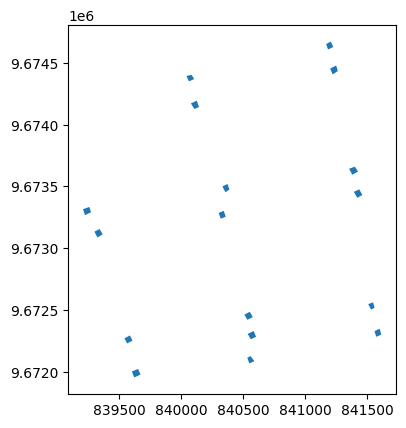

In [14]:
inventory_plot_location.plot()

In [15]:
inventory: pd.DataFrame = pd.read_csv(
    "C:/Users/joaov/Documents/UFMG/TCC/Dataset/DUC_A01_2016_inventory.csv",
    encoding="ISO-8859-1",
)

In [16]:
inventory.head()

,area,plot,tree,common.name,scientific.name,family.name,DBH,type,Dead,D.class,date,UTM.Easting,UTM.Northing
0,DUC_A01,2,001a,macucu,Licania guianensis,Chrysobalanaceae,49.6,O,False,NaN,20160824,840127.0705,9674180.998
1,DUC_A01,2,001b,uxirana,Sacoglottis guianensis,Humiriaceae,43.6,O,False,NaN,20160824,840098.9678,9674177.868
2,DUC_A01,2,002a,mapatirana,Pourouma minor,Urticaceae,31.5,O,False,NaN,20160824,840126.4377,9674180.705
3,DUC_A01,2,002b,abiurana,Pouteria gongrijpii,Sapotaceae,39.2,O,False,NaN,20160824,840109.4829,9674171.803
4,DUC_A01,2,003a,roxinho,Peltogyne lecointei,Fabaceae,10.0,O,False,NaN,20160824,840125.6847,9674181.313


In [17]:
geo_inventory_dataset: geopandas.GeoDataFrame = geopandas.GeoDataFrame(
    inventory,
    geometry=geopandas.points_from_xy(
        inventory["UTM.Easting"], inventory["UTM.Northing"]
    ),
    crs="EPSG:32720",
)

# Splitando os dados do inventário

In [18]:
inventory_splits: geopandas.GeoDataFrame = inventory_plot_location.groupby(
    "plot_ID"
).apply(lambda dataframe: katana(dataframe.geometry.iloc[0], 50, 0))

C:\Users\joaov\AppData\Local\Temp\ipykernel_20044\1883670367.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda dataframe: katana(dataframe.geometry.iloc[0], 50, 0))


In [19]:
inventory_splits = inventory_splits.explode()

In [20]:
inventory_plot_location: geopandas.GeoDataFrame = inventory_plot_location.join(
    inventory_splits.rename("splits"), on="plot_ID"
)

In [21]:
inventory_plot_location["uuid"] = [
    str(uuid.uuid4()) for _ in range(len(inventory_plot_location.index))
]

In [22]:
inventory_plot_location

,plot_ID,geometry,splits,uuid
0,P20,"POLYGON ((840040.725 9674392.229, 840082.852 9...","POLYGON ((840072.2355697429 9674353.521387083,...",fd47a0a7-4439-424d-beda-767f582670c3
0,P20,"POLYGON ((840040.725 9674392.229, 840082.852 9...","POLYGON ((840072.2355697429 9674373.852925414,...",54ce2e19-dc49-4890-8e4a-2dc5f267954f
0,P20,"POLYGON ((840040.725 9674392.229, 840082.852 9...","POLYGON ((840082.8515461604 9674401.42753503, ...",49444736-6181-4d28-a725-8651fa5dea60
1,P02,"POLYGON ((840077.054 9674170.361, 840124.283 9...","POLYGON ((840104.7957429491 9674125.35265339, ...",614c5ebb-aa0b-4d50-a9ca-a5aa2203d829
1,P02,"POLYGON ((840077.054 9674170.361, 840124.283 9...","POLYGON ((840113.3434665299 9674128.948648158,...",d1ffbee1-8971-45e2-98d9-0de0b03a9b9d
...,...,...,...,...
15,P16,"POLYGON ((841509.008 9672549.669, 841548.139 9...","POLYGON ((841548.1392093287 9672563.864811674,...",6052f28e-ff21-4930-8eb7-89cc187fe8c8
16,P19,"POLYGON ((841559.823 9672331.397, 841602.042 9...","POLYGON ((841573.8968711956 9672286.07804048, ...",442eeae6-47da-40b6-bbcb-db51084a08ae
16,P19,"POLYGON ((841559.823 9672331.397, 841602.042 9...","POLYGON ((841588.8606199534 9672292.281449702,...",fe135199-7a41-4825-9557-6895c2e345d9
16,P19,"POLYGON ((841559.823 9672331.397, 841602.042 9...","POLYGON ((841563.7877329019 9672318.630098175,...",0aa1215c-e911-4084-9dba-0576a962e970


In [23]:
del inventory_splits

# Merge inventário com a região

In [24]:
inventory_point_in_poly: geopandas.GeoDataFrame = geopandas.sjoin(
    geo_inventory_dataset,
    inventory_plot_location,
    predicate="within",
    lsuffix="left",
    rsuffix="right",
)

In [25]:
del geo_inventory_dataset

In [26]:
inventory_point_in_poly

,area,plot,tree,common.name,scientific.name,family.name,DBH,type,Dead,D.class,date,UTM.Easting,UTM.Northing,geometry,index_right,plot_ID,splits,uuid
0,DUC_A01,2,001a,macucu,Licania guianensis,Chrysobalanaceae,49.6,O,False,NaN,20160824,840127.0705,9674180.998,POINT (840127.071 9674180.998),1,P02,"POLYGON ((840104.7957429491 9674125.35265339, ...",614c5ebb-aa0b-4d50-a9ca-a5aa2203d829
0,DUC_A01,2,001a,macucu,Licania guianensis,Chrysobalanaceae,49.6,O,False,NaN,20160824,840127.0705,9674180.998,POINT (840127.071 9674180.998),1,P02,"POLYGON ((840113.3434665299 9674128.948648158,...",d1ffbee1-8971-45e2-98d9-0de0b03a9b9d
0,DUC_A01,2,001a,macucu,Licania guianensis,Chrysobalanaceae,49.6,O,False,NaN,20160824,840127.0705,9674180.998,POINT (840127.071 9674180.998),1,P02,"POLYGON ((840084.0592568209 9674158.99484751, ...",b1d189e8-d486-4d0e-bb1e-de6bd1e56694
0,DUC_A01,2,001a,macucu,Licania guianensis,Chrysobalanaceae,49.6,O,False,NaN,20160824,840127.0705,9674180.998,POINT (840127.071 9674180.998),1,P02,"POLYGON ((840136.297330943 9674158.99484751, 8...",9240af61-c9f8-409c-ada8-a8e5e5ff3afd
1,DUC_A01,2,001b,uxirana,Sacoglottis guianensis,Humiriaceae,43.6,O,False,NaN,20160824,840098.9678,9674177.868,POINT (840098.968 9674177.868),1,P02,"POLYGON ((840104.7957429491 9674125.35265339, ...",614c5ebb-aa0b-4d50-a9ca-a5aa2203d829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,DUC_A01,20,051a,louro cheiroso,Diospyros artanthifolia,Ebenaceae,11.9,O,False,NaN,20160830,840069.1150,9674398.094,POINT (840069.115 9674398.094),0,P20,"POLYGON ((840072.2355697429 9674373.852925414,...",54ce2e19-dc49-4890-8e4a-2dc5f267954f
1167,DUC_A01,20,051a,louro cheiroso,Diospyros artanthifolia,Ebenaceae,11.9,O,False,NaN,20160830,840069.1150,9674398.094,POINT (840069.115 9674398.094),0,P20,"POLYGON ((840082.8515461604 9674401.42753503, ...",49444736-6181-4d28-a725-8651fa5dea60
1168,DUC_A01,20,052a,louro pimenta,Ocotea canaliculata,Lauraceae,11.2,O,False,NaN,20160830,840070.2963,9674398.520,POINT (840070.296 9674398.520),0,P20,"POLYGON ((840072.2355697429 9674353.521387083,...",fd47a0a7-4439-424d-beda-767f582670c3
1168,DUC_A01,20,052a,louro pimenta,Ocotea canaliculata,Lauraceae,11.2,O,False,NaN,20160830,840070.2963,9674398.520,POINT (840070.296 9674398.520),0,P20,"POLYGON ((840072.2355697429 9674373.852925414,...",54ce2e19-dc49-4890-8e4a-2dc5f267954f


In [27]:
inventory_point_in_poly = inventory_point_in_poly.set_geometry("splits")

# Encontrando dados LiDAR no inventário

In [28]:
lidar_point_in_plot_location: geopandas.GeoDataFrame = geopandas.sjoin(
    geo_lidar_dataset,
    inventory_point_in_poly,
    predicate="within",
    lsuffix="geo_lidar_dataset",
    rsuffix="inventory_point_in_poly",
)

C:\Users\joaov\AppData\Local\Temp\ipykernel_20044\893940363.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32720
Right CRS: None

  lidar_point_in_plot_location: geopandas.GeoDataFrame = geopandas.sjoin(


In [29]:
lidar_point_in_plot_location = lidar_point_in_plot_location.drop_duplicates(
    subset=["X", "Y", "Z", "return_number"]
)

lidar_point_in_plot_location = lidar_point_in_plot_location.rename(
    {"geometry_inventory_plot_location": "geometry"}, axis=1
)

lidar_point_in_plot_location

,X,Y,Z,intensity,return_number,number_of_returns,classification,geometry_geo_lidar_dataset,index_inventory_point_in_poly,area,...,type,Dead,D.class,date,UTM.Easting,UTM.Northing,geometry_inventory_point_in_poly,index_right,plot_ID,uuid
441390,841200.72,9674664.03,97.12,5,1,1,1,POINT (841200.720 9674664.030),54,DUC_A01,...,O,False,NaN,20160830,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,50eecf7e-0db4-4b05-91b1-04279a3623a3
441466,841200.75,9674664.11,97.45,1,2,2,1,POINT (841200.750 9674664.110),54,DUC_A01,...,O,False,NaN,20160830,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,50eecf7e-0db4-4b05-91b1-04279a3623a3
441468,841200.75,9674664.21,97.22,1,2,2,1,POINT (841200.750 9674664.210),54,DUC_A01,...,O,False,NaN,20160830,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,50eecf7e-0db4-4b05-91b1-04279a3623a3
443938,841202.07,9674659.97,94.90,1,1,1,1,POINT (841202.070 9674659.970),54,DUC_A01,...,O,False,NaN,20160830,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,50eecf7e-0db4-4b05-91b1-04279a3623a3
443939,841202.66,9674668.94,113.64,1,1,1,1,POINT (841202.660 9674668.940),54,DUC_A01,...,O,False,NaN,20160830,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,50eecf7e-0db4-4b05-91b1-04279a3623a3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13054440,841263.27,9674432.63,83.30,6,1,1,1,POINT (841263.270 9674432.630),131,DUC_A01,...,P,False,NaN,20160830,841245.0043,9674466.817,POINT (841245.004 9674466.817),9,P05,e759d97b-b950-47b9-82db-5a7145fd3e3f
13054441,841263.19,9674432.22,83.65,3,1,1,1,POINT (841263.190 9674432.220),131,DUC_A01,...,P,False,NaN,20160830,841245.0043,9674466.817,POINT (841245.004 9674466.817),9,P05,e759d97b-b950-47b9-82db-5a7145fd3e3f
13054442,841263.11,9674431.92,83.55,3,1,1,1,POINT (841263.110 9674431.920),131,DUC_A01,...,P,False,NaN,20160830,841245.0043,9674466.817,POINT (841245.004 9674466.817),9,P05,e759d97b-b950-47b9-82db-5a7145fd3e3f
13054443,841263.03,9674431.57,83.69,8,1,1,1,POINT (841263.030 9674431.570),131,DUC_A01,...,P,False,NaN,20160830,841245.0043,9674466.817,POINT (841245.004 9674466.817),9,P05,e759d97b-b950-47b9-82db-5a7145fd3e3f


In [30]:
lidar_point_in_plot_location[
    lidar_point_in_plot_location["number_of_returns"] == 2
].sort_values(["X", "Y", "Z"])

,X,Y,Z,intensity,return_number,number_of_returns,classification,geometry_geo_lidar_dataset,index_inventory_point_in_poly,area,...,type,Dead,D.class,date,UTM.Easting,UTM.Northing,geometry_inventory_point_in_poly,index_right,plot_ID,uuid
5326238,841169.37,9674649.10,112.64,5,1,2,1,POINT (841169.370 9674649.100),54,DUC_A01,...,O,False,NaN,20160830,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,f1bd4a1d-a53e-4889-9506-14d18212b405
11551489,841169.98,9674647.45,90.03,1,2,2,1,POINT (841169.980 9674647.450),54,DUC_A01,...,O,False,NaN,20160830,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,f1bd4a1d-a53e-4889-9506-14d18212b405
11545072,841170.47,9674645.76,113.93,1,1,2,1,POINT (841170.470 9674645.760),54,DUC_A01,...,O,False,NaN,20160830,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,f1bd4a1d-a53e-4889-9506-14d18212b405
11545073,841170.60,9674645.38,110.13,1,2,2,1,POINT (841170.600 9674645.380),54,DUC_A01,...,O,False,NaN,20160830,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,f1bd4a1d-a53e-4889-9506-14d18212b405
11545067,841170.61,9674647.07,114.42,6,1,2,1,POINT (841170.610 9674647.070),54,DUC_A01,...,O,False,NaN,20160830,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,f1bd4a1d-a53e-4889-9506-14d18212b405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11025716,841262.71,9674433.42,82.08,1,1,2,1,POINT (841262.710 9674433.420),131,DUC_A01,...,P,False,NaN,20160830,841245.0043,9674466.817,POINT (841245.004 9674466.817),9,P05,e759d97b-b950-47b9-82db-5a7145fd3e3f
11025712,841262.78,9674433.25,79.08,1,1,2,1,POINT (841262.780 9674433.250),131,DUC_A01,...,P,False,NaN,20160830,841245.0043,9674466.817,POINT (841245.004 9674466.817),9,P05,e759d97b-b950-47b9-82db-5a7145fd3e3f
11025923,841262.82,9674433.78,78.85,7,1,2,1,POINT (841262.820 9674433.780),131,DUC_A01,...,P,False,NaN,20160830,841245.0043,9674466.817,POINT (841245.004 9674466.817),9,P05,e759d97b-b950-47b9-82db-5a7145fd3e3f
4893094,841262.83,9674433.07,82.20,7,1,2,1,POINT (841262.830 9674433.070),131,DUC_A01,...,P,False,NaN,20160830,841245.0043,9674466.817,POINT (841245.004 9674466.817),9,P05,e759d97b-b950-47b9-82db-5a7145fd3e3f


# Feature extraction

In [31]:
inventory_point_in_poly[inventory_point_in_poly["plot_ID"] == "P02"].splits.unique()

<GeometryArray>
[<POLYGON ((840104.796 9674125.353, 840084.059 9674158.995, 840113.343 967415...>,
 <POLYGON ((840113.343 9674128.949, 840113.343 9674158.995, 840136.297 967415...>,
 <POLYGON ((840084.059 9674158.995, 840077.054 9674170.361, 840106.675 967418...>,
 <POLYGON ((840136.297 9674158.995, 840106.675 9674158.995, 840106.675 967418...>]
Length: 4, dtype: geometry

In [32]:
lidar_point_in_plot_location = lidar_point_in_plot_location.merge(
    inventory_point_in_poly.groupby(["plot_ID", "uuid"])["DBH"]
    .mean()
    .reset_index()
    .rename({"DBH": "mean_dbh"}, axis=1),
    on=["plot_ID", "uuid"],
    how="left",
)

In [33]:
lidar_point_in_plot_location = lidar_point_in_plot_location.merge(
    inventory_point_in_poly.groupby(["plot_ID", "uuid"])["DBH"]
    .std()
    .reset_index()
    .rename({"DBH": "std_dbh"}, axis=1),
    on=["plot_ID", "uuid"],
    how="left",
)

In [34]:
lidar_point_in_plot_location = lidar_point_in_plot_location.merge(
    inventory_point_in_poly.groupby(["plot_ID", "uuid"])["DBH"]
    .max()
    .reset_index()
    .rename({"DBH": "max_dbh"}, axis=1),
    on=["plot_ID", "uuid"],
    how="left",
)

In [35]:
lidar_point_in_plot_location = lidar_point_in_plot_location.merge(
    inventory_point_in_poly.groupby(["plot_ID", "uuid"])["DBH"]
    .min()
    .reset_index()
    .rename({"DBH": "min_dbh"}, axis=1),
    on=["plot_ID", "uuid"],
    how="left",
)

In [36]:
lidar_point_in_plot_location = lidar_point_in_plot_location.drop_duplicates(
    subset=["X", "Y", "Z", "uuid"]
)

In [37]:
lidar_point_in_plot_location

,X,Y,Z,intensity,return_number,number_of_returns,classification,geometry_geo_lidar_dataset,index_inventory_point_in_poly,area,...,UTM.Easting,UTM.Northing,geometry_inventory_point_in_poly,index_right,plot_ID,uuid,mean_dbh,std_dbh,max_dbh,min_dbh
0,841200.72,9674664.03,97.12,5,1,1,1,POINT (841200.720 9674664.030),54,DUC_A01,...,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,50eecf7e-0db4-4b05-91b1-04279a3623a3,24.318182,15.867765,73.9,10.0
1,841200.75,9674664.11,97.45,1,2,2,1,POINT (841200.750 9674664.110),54,DUC_A01,...,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,50eecf7e-0db4-4b05-91b1-04279a3623a3,24.318182,15.867765,73.9,10.0
2,841200.75,9674664.21,97.22,1,2,2,1,POINT (841200.750 9674664.210),54,DUC_A01,...,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,50eecf7e-0db4-4b05-91b1-04279a3623a3,24.318182,15.867765,73.9,10.0
3,841202.07,9674659.97,94.90,1,1,1,1,POINT (841202.070 9674659.970),54,DUC_A01,...,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,50eecf7e-0db4-4b05-91b1-04279a3623a3,24.318182,15.867765,73.9,10.0
4,841202.66,9674668.94,113.64,1,1,1,1,POINT (841202.660 9674668.940),54,DUC_A01,...,841204.2869,9674667.625,POINT (841204.287 9674667.625),8,P04,50eecf7e-0db4-4b05-91b1-04279a3623a3,24.318182,15.867765,73.9,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89720,841263.27,9674432.63,83.30,6,1,1,1,POINT (841263.270 9674432.630),131,DUC_A01,...,841245.0043,9674466.817,POINT (841245.004 9674466.817),9,P05,e759d97b-b950-47b9-82db-5a7145fd3e3f,24.008333,16.476098,100.0,10.6
89721,841263.19,9674432.22,83.65,3,1,1,1,POINT (841263.190 9674432.220),131,DUC_A01,...,841245.0043,9674466.817,POINT (841245.004 9674466.817),9,P05,e759d97b-b950-47b9-82db-5a7145fd3e3f,24.008333,16.476098,100.0,10.6
89722,841263.11,9674431.92,83.55,3,1,1,1,POINT (841263.110 9674431.920),131,DUC_A01,...,841245.0043,9674466.817,POINT (841245.004 9674466.817),9,P05,e759d97b-b950-47b9-82db-5a7145fd3e3f,24.008333,16.476098,100.0,10.6
89723,841263.03,9674431.57,83.69,8,1,1,1,POINT (841263.030 9674431.570),131,DUC_A01,...,841245.0043,9674466.817,POINT (841245.004 9674466.817),9,P05,e759d97b-b950-47b9-82db-5a7145fd3e3f,24.008333,16.476098,100.0,10.6


In [38]:
ids = lidar_point_in_plot_location["uuid"].unique()

In [39]:
lidar_point_in_plot_location[lidar_point_in_plot_location["uuid"] == ids[0]][
    "Z"
].describe()

count    7335.000000
mean      117.988285
std         7.643603
min        91.320000
25%       115.915000
50%       120.550000
75%       123.365000
max       127.460000
Name: Z, dtype: float64

### Probability Density Function

In [40]:
density = scipy.stats.gaussian_kde(
    lidar_point_in_plot_location[lidar_point_in_plot_location["uuid"] == ids[0]]["Z"]
)

In [41]:
x = np.linspace(60, 200, 200)
y = density(x)
data = pd.DataFrame(data=np.vstack([x, y]).transpose(), columns=["X", "Y"])

<Axes: xlabel='X', ylabel='Y'>

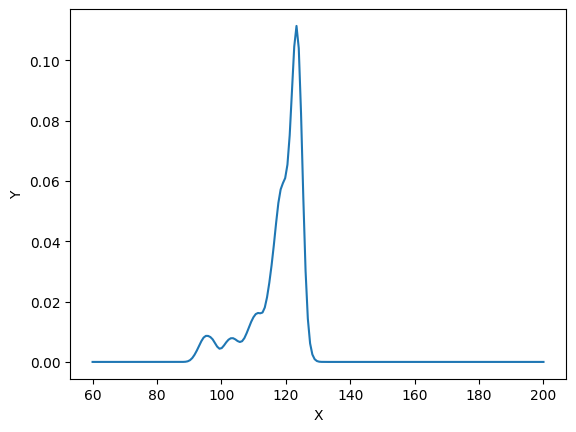

In [42]:
sns.lineplot(data, x="X", y="Y")

### Histogram

https://stackoverflow.com/questions/73286233/how-to-calculate-the-probability-between-two-numbers-from-a-probability-distribu

In [43]:
bins = 10

<Axes: xlabel='Z', ylabel='Count'>

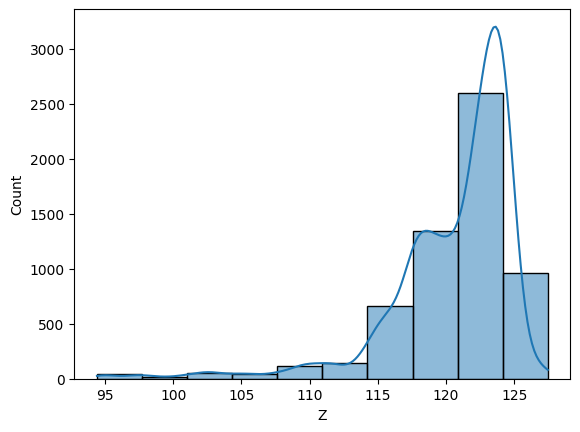

In [44]:
sns.histplot(
    data=lidar_point_in_plot_location[
        (lidar_point_in_plot_location["uuid"] == ids[0])
        & (lidar_point_in_plot_location["return_number"] == 1)
    ]["Z"],
    bins=bins,
    kde=True
)

<Axes: xlabel='Z', ylabel='Count'>

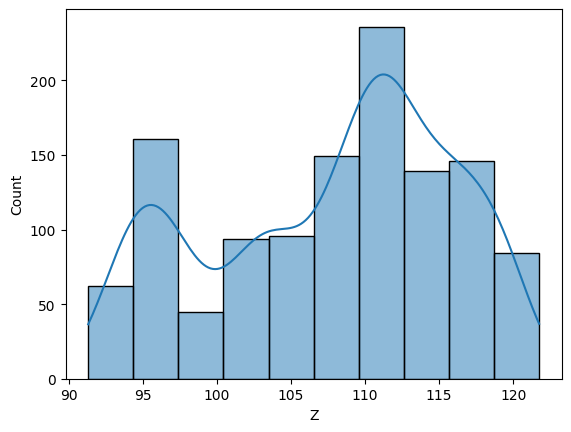

In [45]:
sns.histplot(
    data=lidar_point_in_plot_location[
        (lidar_point_in_plot_location["uuid"] == ids[0])
        & (lidar_point_in_plot_location["return_number"] == 2)
    ]["Z"],
    bins=bins,
    kde=True
)

In [46]:
first_returns_hist, first_returns_bin_edges = np.histogram(
    lidar_point_in_plot_location[
        (lidar_point_in_plot_location["uuid"] == ids[0])
        & (lidar_point_in_plot_location["return_number"] == 1)
    ]["Z"],
    bins=bins,
    # density=True,
    range=(90, 130)
)

In [47]:
first_returns_hist, first_returns_bin_edges

(array([   0,   40,   31,   66,   92,  168,  893, 1640, 2974,   67],
       dtype=int64),
 array([ 90.,  94.,  98., 102., 106., 110., 114., 118., 122., 126., 130.]))

In [48]:
second_returns_hist, second_returns_bin_edges = np.histogram(
    lidar_point_in_plot_location[
        (lidar_point_in_plot_location["uuid"] == ids[0])
        & (lidar_point_in_plot_location["return_number"] == 2)
    ]["Z"],
    bins=bins,
    # density=True,
    range=(90, 130)
)

In [49]:
second_returns_hist, second_returns_bin_edges

(array([ 49, 194,  72, 134, 180, 275, 196, 112,   0,   0], dtype=int64),
 array([ 90.,  94.,  98., 102., 106., 110., 114., 118., 122., 126., 130.]))

In [50]:
complete_hist = np.zeros((bins, bins))

complete_hist[:,0] = first_returns_hist

In [51]:
for i,j in enumerate(range(0, bins)):
    complete_hist[i,j] = second_returns_hist[i]

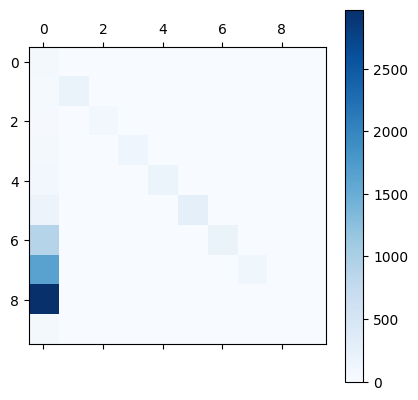

In [52]:
plt.matshow(complete_hist, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

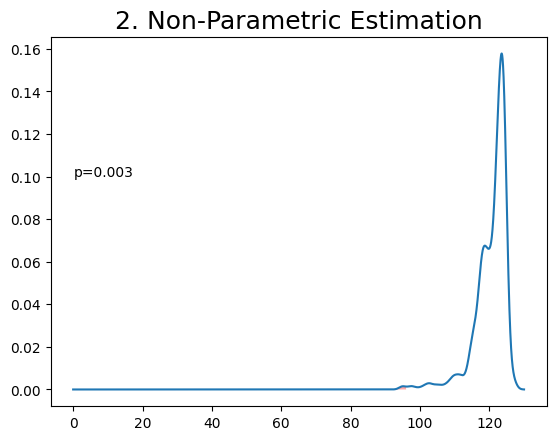

In [63]:
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad

lower, upper = 90, 96

# x = [-0.804, -2.267, 1.55, -1.004, 3.173, -0.522, -0.231, 3.95, -0.574, -0.213, 1.333, 2.42, 1.879, 3.814]

x_axis = np.linspace(0, 130, 10000)

x = lidar_point_in_plot_location[
    (lidar_point_in_plot_location["uuid"] == ids[0])
    & (lidar_point_in_plot_location["return_number"] == 1)
]["Z"].to_numpy()

# fit density function
f_hat = KernelDensity(bandwidth=0.9, kernel="gaussian").fit(np.array(x).reshape(-1, 1))


def f_pred(x):
    """wrapper function to compute probability"""
    return np.exp(f_hat.score_samples(np.array(x).reshape(-1, 1)))[0]


p = quad(func=f_pred, a=lower, b=upper)

# plot
plt.title("2. Non-Parametric Estimation", fontsize=18)
xaxis = np.linspace(0, 130, 10000)
plt.plot(x_axis, np.exp(f_hat.score_samples(xaxis.reshape(-1, 1))))
plt.fill_between(
    x=np.arange(lower, upper, 0.01),
    y1=np.exp(f_hat.score_samples(np.arange(lower, upper, 0.01).reshape(-1, 1))),
    facecolor="red",
    alpha=0.35,
)
plt.text(x=0.15, y=0.1, s="p=" + str(round(p[0], 3)))
plt.show()